In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score


fim_posicao= pd.read_excel('fim_posicao_queen.xlsx', sheet_name=0)
meio_posicao= fim_posicao

In [3]:
df = meio_posicao.copy()
features = ['bom', 'ruim', 'media', 'idade']
X = df[features]
y = df['vencedora']

In [4]:
groups = df['tempfranquia']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
gss

GroupShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None)

In [5]:
train_idx, test_idx = next(gss.split(X, y, groups=groups))

In [6]:
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print("Temporadas no treino:", df['tempfranquia'].iloc[train_idx].unique())
print("Temporadas no teste:", df['tempfranquia'].iloc[test_idx].unique())

Temporadas no treino: [ 201  301  401  501  701  801  901 1001 1101 1201 1301 1401 1501 1601
  102  202  302  402  502  602  103  204  304  404  504  109  105  205
  305 1011 3011 4011 1013 2013 3013 1015 3015 2014 3014 1012 2012 1016
  307  203 1801 1901]
Temporadas no teste: [ 101  601  104  209 2011 2015 1014  106  206 1018 1701 1802]


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# REGRESSÃO LINEAR
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
probabilidades_vencedora = logreg.predict_proba(X_test_scaled)
probs = probabilidades_vencedora[:, 1]  # pegar só probabilidade de vencer

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.68      0.77        40
           1       0.38      0.73      0.50        11

    accuracy                           0.69        51
   macro avg       0.64      0.70      0.64        51
weighted avg       0.79      0.69      0.71        51

[[27 13]
 [ 3  8]]


In [9]:
probabilidades = probabilidades_vencedora[:, 1]

# Crie um DataFrame para visualizar os resultados
# Lembre-se que o X_test precisa ter os nomes das queens para esta visualização
# Use o índice do X_test para pegar as rainhas do DataFrame original
queens_do_teste =meio_posicao.loc[X_test.index, 'queen']

# Crie um DataFrame para visualizar os resultados
resultados = pd.DataFrame({
    'queen': queens_do_teste,
    'Chance de Vencer (%)': probabilidades * 100
})

resultados['Chance de Vencer (%)'] = resultados['Chance de Vencer (%)'].round(2)

print("--- Chance de cada rainha ganhar ---")
print(resultados.sort_values(by='Chance de Vencer (%)', ascending=False))

--- Chance de cada rainha ganhar ---
                     queen  Chance de Vencer (%)
20          Bianca Del Rio                 94.86
179                 Keiona                 93.90
148               Sharonne                 92.05
218              Eva Blunt                 88.24
190         Marina Summers                 85.49
97           Scarlett BoBo                 84.44
229             Onya Nurve                 72.95
1             Nina Flowers                 71.95
123         My Little Puny                 64.16
189  Precious Paula Nicole                 63.09
150      Venedita Von Däsh                 62.79
180           Sara Forever                 61.49
223             Metamorkid                 61.20
125             Keta Minaj                 59.47
216            Regina Voce                 58.76
0        BeBe Zahara Benet                 56.41
222            Pandora Nox                 56.20
233             Suzie Toot                 55.29
241                 Cheryl      

In [10]:
roc_auc = roc_auc_score(y_test, probs)
print("ROC-AUC:", roc_auc)
print("-------------------------------")
df_ranking = pd.DataFrame({
    "queen": df.loc[y_test.index, "queen"],
    "temporada": df.loc[y_test.index, "tempfranquia"],
    "real": y_test,
    "prob_vencer": probs
})

# ordenar por probabilidade de vencer
df_ranking = df_ranking.sort_values(["temporada", "prob_vencer"], ascending=[True, False])

# ver top 1 ou top 2 de cada temporada
top_1 = df_ranking.groupby("temporada").head(1)
print(top_1)


ROC-AUC: 0.8022727272727272
-------------------------------
              queen  temporada  real  prob_vencer
1      Nina Flowers        101     0     0.719545
97    Scarlett BoBo        104     0     0.844381
216     Regina Voce        106     0     0.587628
218       Eva Blunt        206     1     0.882419
123  My Little Puny        209     0     0.641601
20   Bianca Del Rio        601     1     0.948624
190  Marina Summers       1014     0     0.854919
223      Metamorkid       1018     1     0.611956
229      Onya Nurve       1701     1     0.729470
241          Cheryl       1802     0     0.549014
148        Sharonne       2011     1     0.920490
179          Keiona       2015     1     0.939044


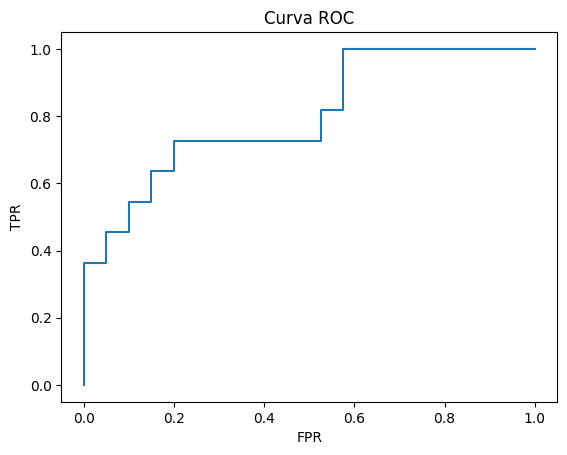

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.show()


In [12]:
resultados.to_excel('./previsoes/fim_previsoes_vencedoras.xlsx', index=False)
